3D SLAM with Lie Group SE(3), Barfoot.

Transformation Matrix 

At time k,
 
$T_{k} = \begin{bmatrix} {}^{i}C^{v_{k}} &  - {}^{i}C^{v_{k}} {}^{i}r^{v_{k}} \\ 0_{1x3} & 1 \end{bmatrix} \in SE(3)$

where <br>
$^{i}C^{v_{k}}$ is rotation matrix from inertial frame to vehicl (body) frame at time k <br>
$^{i}r^{v_{k}}$ is translation vector from origin of inertial frame to the orgin point of vehicle frame at time k


Error Cost Function

At time k,

$e_{k} = \sum_{j} (y_{k} - T_{k} * p_{j})$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import casadi as ca

In [2]:
def getRotationMat(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta) , np.cos(theta), 0], [0, 0, 1]])

In [3]:
def data_association(x: np.array, z: np.array, landmarks: np.array):
    """
    Associates measurement with known landmarks using maximum likelihood
    
    @param x: state of vehicle
    @param z: measurement [x,y,z]
    @param landmarks: map of known landmarks
    """
    dm = landmarks - x
    z_error_list = np.array(dm) - np.array([z])
    # TODO: Make an actual number. Covariance of the measurement
    Q = np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]])
    Q_I = np.linalg.inv(Q)
    J_list = []
    for z_error in z_error_list:
        J_list.append(z_error.T@Q_I@z_error)
    J_list = np.array(J_list)
    i = np.argmin(J_list)
    return i

In [4]:
def measure_landmark(Rot, x , landmarks, noise=None, range_max=4):
    """
    @param
    Rot: rotation matrix of the vehicle's orientation
    Trans: Translation  of the vehicle's frame
    x: state of the vehicle in inertial frame
    m: all landmarks in inertial frame
    
    @return
    z_list: list of landmarks observed by the vehicle at time k in body frame
    
    """
    
    z_list = []
    for m in landmarks:
        dm = m - x
        if noise is not None:
            dm[0] += noise['x_std']*np.random.randn()
            dm[1] += noise['y_std']*np.random.randn()
            dm[2] += noise['z_std']*np.random.randn()
        
        dist = np.linalg.norm(dm , 1)
        
        m_body = np.matmul(Rot , dm)
        
        if dist <= range_max:
            z_list.append(m_body)
            
    return np.array(z_list)
            

In [5]:
def measure_odom(x, x_prev, noise=None):
    dx = x - x_prev
    d = np.linalg.norm(dx)
    theta = np.arctan2(dx[1], dx[0])
    odom = dx
    if noise is not None:
        #for R matrix, make it 3x3
        R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
        odom += d*(noise['odom_std']*np.random.randn(3) + R@np.array([noise['odom_bx_bias'], noise['odom_by_bias'], noise['odom_bz_bias']]))#right now this is only positive noise, only overestimates 
        #TODO add z noise
    return list(odom)

In [12]:
def build_cost(T , p , y, assoc):
    """
    T: Transformation Matrix [Rot , x]
    p: landmarks 1,..,j observed at time k
    y: measurement 1,...,j at time k
    """
    
    # covariance for measurement
    Q = ca.SX(3, 3) 
    rng_std = .5
    bearing_std = .5
    pitch_std = 1
    Q[0, 0] = rng_std**2
    Q[1, 1] = bearing_std**2
    Q[2 ,2] = pitch_std**2
    Q_I = ca.inv(Q)
    
    #scalar weight -- should be different for each landmarks
    w = 0.7
                        
    # build cost
    J = ca.SX.zeros(1,1)
        
    for j in range(len(y)):
        li = assoc[j] #index for landmarks
        
        e_y = ca.SX.zeros(1,3)
        
        #e_y = y - T * p (from Barfoot) 
        e_y = y[j,:3] - ca.mtimes(T[0], (p[li] - T[1].T))
        
        # cost
        J += e_y.T@Q_I@e_y
    return J

In [13]:
def build_constraint(R):
    
    #Constraint 1: det(R) = 1
    G1 = ca.SX.zeros(1,1)
    a = R[0,0]
    b = R[1,0]
    c = R[2,0]
    d = R[0,1]
    e = R[1,1]
    f = R[2,1]
    g = R[0,2]
    h = R[1,2]
    i = R[2,2]
    G1 = a*e*i + d*h*c + g*b*f - (c*e*g + f*h*a + i*b*d) - 1
    
    #Constraint 2: R^{-1} == R^{T}
    Ainv = ca.inv(R)
    Atrans = R.T
    G2 = ca.SX.zeros(9,1)
    G2[0] = Ainv[0,0] - Atrans[0,0]
    G2[1] = Ainv[0,1] - Atrans[0,1]
    G2[2] = Ainv[0,2] - Atrans[0,2]
    G2[3] = Ainv[1,0] - Atrans[1,0]
    G2[4] = Ainv[1,1] - Atrans[1,1]
    G2[5] = Ainv[1,2] - Atrans[1,2]
    G2[6] = Ainv[2,0] - Atrans[2,0]
    G2[7] = Ainv[2,1] - Atrans[2,1]
    G2[8] = Ainv[2,2] - Atrans[2,2]
    G = ca.vertcat(G1 , G2)

    
    return G
    
    

In [20]:
#------------------------
# Define constant

deg_to_rad = np.pi / 180

noise={
    'odom_std': 0.0,
    'x_std': 0.0,
    'y_std': 0.0,
    'z_std': 0.0,
    'odom_bx_bias': 0.1,
    'odom_by_bias': 0.0,
    'odom_bz_bias': 0.0
}

#------------------------
# Initialize states

#input pair: [dist , heading angle]
u = np.array([[3   , 0],
             [5    , 53 * deg_to_rad],
             [1    , 1.5*np.pi/2],
             [2    , np.pi]])

tf = len(u)
dt = 1

#Define landmarks
"""
Currently have issue with optimizing with multiple landmarks
Issue: cost function
"""
landmarks = np.array([
                     [3,4,0]])

#Define true state variable x described in inertial frame
xi = np.array([0.,0.,0.]);
x_prev = xi;
Rot0 = np.identity(3)

#Define estimated state wrt inetial frame
xh = np.array([xi])
Roth = Rot0

# Symbolic estimated states and landmark
xh_sym = ca.SX.sym('xh0', 1, 3)
Roth_sym = ca.SX.sym('Roth0', 3, 3)
J = ca.SX.zeros(1,1)

hist = {'x': [xi],
        'z': [],
        'R':  [Rot0],
        'xh': [xi],
        'Rh': [Rot0],
       'Frame': ['inertial']};

#------------------------
#Begin Simulation

t_vect = np.arange(0,tf,dt)
print(t_vect)
for k, tk in enumerate(t_vect):
    
    #Assign Rotation and translation Input
    # rotate then move
    uk = u[k]
    
    Rotk   = getRotationMat(uk[1])
    uTrans_k = np.array([uk[0] * np.cos(uk[1]) , uk[0] * np.sin(uk[1]), 0])
    
    #Update State variables
    xk = x_prev + uTrans_k; 
    
    #Append new estimated state
    odom = measure_odom(xk, x_prev, noise)
    xh = np.vstack([xh, xh[-1,:]+odom])
    
    theta_h = np.arctan2((xh[-1,1] - xh[-2,1]) , (xh[-1,0] - xh[-2,0]))
    Roth    = np.vstack([Roth, getRotationMat(theta_h)])
    
    #Append new estimate symbolic variable
    xh_sym = ca.vertcat(xh_sym, ca.SX.sym('xh'+str(k+1), 1, 3))
    Roth_sym = ca.vertcat(Roth_sym, ca.SX.sym('Roth'+str(k+1), 3, 3))
    
    #Measure landmarks
    zk = measure_landmark(Rotk, xk, landmarks, noise)
        
    #Transformation Matrix
    T = [Roth_sym[-3: , :] , xh_sym[-1 , :]]
    
    assoc = [ data_association(xh[-2,:], zi, landmarks) for zi in zk ]

    #Update cost function
    J += build_cost(T , landmarks, zk, assoc)
        
    #Re-assign previous state
    x_prev = xk

    #--------------------------------------
    
    #Non-linear programming
    #   for point cloud alignment problem, we are solving for "T" only which include of:
    # - rotation matrix from inertial-frame to vehicle-frame
    # - translation vector describing the vehicle's pose in inertial-frame
    
    nlp = {}                 # NLP declaration
    x_temp = xh_sym.T.reshape((xh_sym.shape[0]*3,1))
    Rot_temp = Roth_sym.T.reshape((Roth_sym.shape[0]*3,1))
    
    G = build_constraint(Roth_sym[-3:, :])
    
    nlp['x']= ca.vertcat(x_temp, Rot_temp)       # decision vars
    nlp['f'] = J      # objective
    nlp['g'] = G      # constraints
    
    # Create solver instance
    opts = {'ipopt.print_level':0, 'print_time':0, 'ipopt.sb': 'yes'}
    F = ca.nlpsol('F','ipopt',nlp, opts);

    # Solve the problem using a guess
    x_input = np.hstack([np.array(xh).reshape(-1), Roth.reshape(-1)])
    optim = F(x0=x_input,ubg=0,lbg=0)
    n_x = len(xh)
    n_r = len(Roth)
    xh = np.reshape(optim['x'][0:3*n_x], [n_x,3])    # Best estimate of all states for all times at time i
    Roth = np.reshape(optim['x'][-n_r*3: , :], [n_r,3]) # Best estimate of all rotation matrix at time i
    
    #------------------------------------------------
    
    #Append "true state" history
    hist['x'].append(xk)
    hist['R'].append(Rotk)
    hist['Frame'].append(k)
    for zi in zk:
        hist['z'].append(np.hstack([zi, k]))      # History of measurements recorded at each time step
    
    #Append "best estimate at time k" history
    hist['xh'].append(xh[-1])
    hist['Rh'].append(Roth[-3: , :])
 
    
for key in hist.keys():
    hist[key] = np.array(hist[key])

cost = float(optim['f'])   
print("cost:" , cost)  
hist

[0 1 2 3]
cost: 1.0031334042046528e-09


{'x': array([[0.        , 0.        , 0.        ],
        [3.        , 0.        , 0.        ],
        [6.00907512, 3.99317755, 0.        ],
        [5.30196833, 4.70028433, 0.        ],
        [3.30196833, 4.70028433, 0.        ]]),
 'z': array([[ 0.        ,  4.        ,  0.        ,  0.        ],
        [-1.81635526, -2.39904839,  0.        ,  1.        ],
        [ 2.12291322, -1.13256162,  0.        ,  2.        ],
        [ 0.30196833,  0.70028433,  0.        ,  3.        ]]),
 'R': array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
 
        [[ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
 
        [[ 6.01815023e-01, -7.98635510e-01,  0.00000000e+00],
         [ 7.98635510e-01,  6.01815023e-01,  0.00000000e+00],
 

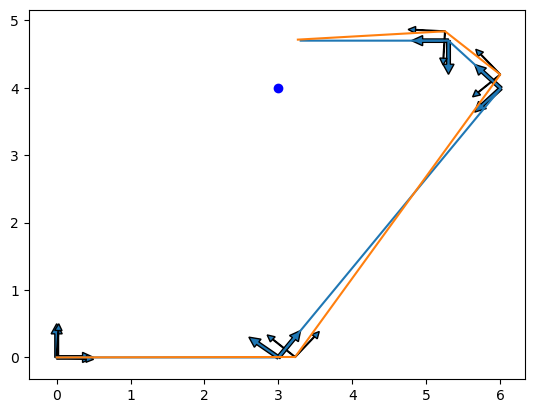

In [21]:
#Plot true vs. estimated state
plt.plot(hist['x'][:, 0] , hist['x'][: , 1])
plt.plot(hist['xh'][:, 0] , hist['xh'][: , 1])

#Plot arrow for orientation (arrow is assumed to be equivalent to x-axis of the body frame)
x = hist['x']
Rot = hist['R']
for i in range(len(x)):
    
    if i == 0:
        continue     
    x_temp = np.matmul(Rot[i] , [0.5 , 0 , 0])
    y_temp = np.matmul(Rot[i]@getRotationMat(np.pi/2) , [0.5 , 0 , 0])
    plt.arrow(x[i - 1,0] , x[i - 1, 1] , x_temp[0] , x_temp[1], width=0.05, length_includes_head=True, head_width=0.15,head_length=0.15)
    plt.arrow(x[i - 1,0] , x[i - 1, 1] , y_temp[0] , y_temp[1], width=0.05, length_includes_head=True, head_width=0.15,head_length=0.15)
    
xh = hist['xh']
Roth = hist['Rh']
for i in range(len(xh)):
    
    if i == 0:
        continue
    x_temp = np.matmul(Roth[i] , [0.5 , 0 , 0])
    y_temp = np.matmul(Roth[i]@getRotationMat(np.pi/2) , [0.5 , 0 , 0])
    plt.arrow(xh[i - 1,0] , xh[i - 1, 1] , x_temp[0] , x_temp[1], width=0.01, length_includes_head=True, head_width=0.1,head_length=0.1)
    plt.arrow(xh[i - 1,0] , xh[i - 1, 1] , y_temp[0] , y_temp[1], width=0.01, length_includes_head=True, head_width=0.1,head_length=0.1)
    
#Plot Landmarks
for m in landmarks:
    plt.plot(m[0],m[1],'bo')
    
#Plot measurement
# for zi in hist['z']:
#     plt.arrow(hist['x'][i, 0] , hist['x'][i, 1], np.matmul(Rot[i].T , zi[:3])[0] ,np.matmul(Rot[i].T , zi[:3])[1], width=0.1, length_includes_head=True)